# Transferring Geometric Style with Warping

In this notebook, we demonstrate the differentiable warping module we use in our work to transfer geometry style:
```
Deformable Style Transfer. Sunnie S. Y. Kim, Nicholas Kolkin, Jason Salavon and Gregory Shakhnarovich. European Conference on Computer Vision (ECCV) 2020.
```

Paper: https://arxiv.org/abs/2003.11038  
Code: https://github.com/sunniesuhyoung/DST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from utils_misc import pil_loader, pil_resize_long_edge_to, pil_to_tensor
from warp import image_warp, apply_warp, umeyama

In [2]:
im_size = 256
device = 'cpu'

## 1. Load content and style images

In [3]:
content_path = 'example/content.jpg'
style_path = 'example/style.jpg'

In [4]:
content_pil = pil_loader(content_path)
style_pil = pil_loader(style_path)
content_resized = pil_resize_long_edge_to(content_pil, im_size)
style_resized = pil_resize_long_edge_to(style_pil, im_size)

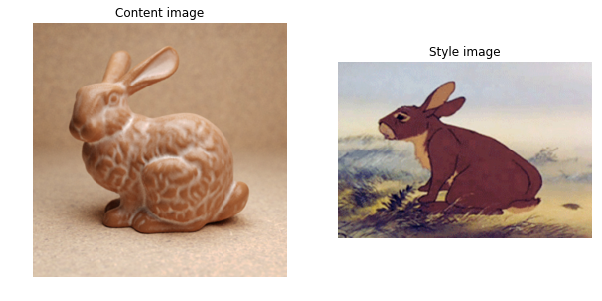

In [5]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(content_resized);
plt.axis('off')
plt.title('Content image');

plt.subplot(1, 2, 2)
plt.imshow(style_resized);
plt.axis('off')
plt.title('Style image');

## 2. Load matching keypoints

In [6]:
content_pts_path = 'example/CleanedPts/correspondence_A.txt'
style_pts_path = 'example/CleanedPts/correspondence_B.txt'

In [7]:
content_pts = np.loadtxt(content_pts_path, delimiter=',')
style_pts = np.loadtxt(style_pts_path, delimiter=',')

In [8]:
# Rescale points (assuming that points are in the original image's scale)
c_width, c_height = content_pil.size
c_fac = im_size/max(c_width, c_height)
for i in range(content_pts.shape[0]):
    content_pts[i][0] *= c_fac
    content_pts[i][1] *= c_fac

s_width, s_height = style_pil.size
s_fac = im_size/max(s_width, s_height)
for i in range(style_pts.shape[0]):
    style_pts[i][0] *= s_fac
    style_pts[i][1] *= s_fac

In [9]:
# Assign colors to each pair of points
np.random.seed(1)
colors = []
for j in range(content_pts.shape[0]):
    colors.append(np.random.random(size=3))

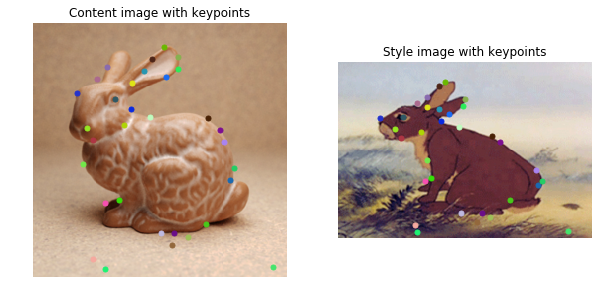

In [10]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(content_resized);
for j in range(content_pts.shape[0]):
    plt.plot(content_pts[j][1], content_pts[j][0], marker='o', color=colors[j], markersize=5)
plt.axis('off')
plt.title('Content image with keypoints');
    
plt.subplot(1, 2, 2)
plt.imshow(style_resized);
for j in range(style_pts.shape[0]):
    plt.plot(style_pts[j][1], style_pts[j][0], marker='o', color=colors[j], markersize=5)
plt.axis('off')
plt.title('Style image with keypoints');

## 3. Transform style image keypoints to get "target points"

Specifically, we find a linear similarity transformation that will minimize the squared distance between the two point clusters.

In [11]:
width, height = content_resized.size

In [12]:
# Transform the style image keypoints
T = umeyama(src=content_pts, dst=style_pts, estimate_scale=True)
target_pts_padded = np.concatenate((style_pts, np.ones((style_pts.shape[0], 1))), 1)
target_pts = np.matmul(np.linalg.inv(T), target_pts_padded.T)
target_pts = target_pts[:2].T

In [13]:
# Clip target points so that they don't go outside the boundary
target_pts[:,0] = np.clip(target_pts[:,0], 0, height)
target_pts[:,1] = np.clip(target_pts[:,1], 0, width)

# Set source points to the content points
source_pts = content_pts

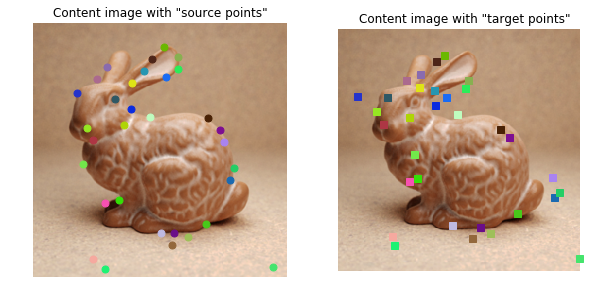

In [14]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(content_resized);
for j in range(source_pts.shape[0]):
    plt.plot(source_pts[j][1], source_pts[j][0], marker='o', color=colors[j], markersize=7)
plt.axis('off')
plt.title('Content image with "source points"');

plt.subplot(1, 2, 2)
plt.imshow(content_resized);
for j in range(target_pts.shape[0]):
    plt.plot(target_pts[j][1], target_pts[j][0], marker='s', color=colors[j], markersize=7)
plt.axis('off')
plt.title('Content image with "target points"');

## 4. (Optionally) add fixed points at the border to prevent undesirable warp artifacts

In [15]:
src_pts = torch.from_numpy(source_pts).float()
tgt_pts = torch.from_numpy(target_pts).float()

src_pts_aug = src_pts
dst_pts_aug = tgt_pts

In [16]:
if True:
    num_pts = 80
    w_d = width//(num_pts+1)
    w_pts = w_d*(np.arange(num_pts)+1)
    h_d = height//(num_pts+1)
    h_pts = h_d*(np.arange(num_pts)+1)

    border_pts = [[0, 0], [height-1, 0], [0, width-1], [height-1, width-1]]
    for i in range(10):
        border_pts.append([h_pts[i], 0])
        border_pts.append([h_pts[i], width-1])
        border_pts.append([0, w_pts[i]])
        border_pts.append([height-1, w_pts[i]])
    border_pts = torch.from_numpy(np.asarray(border_pts)).float()

    no_flow = [[0., 0.]] * len(border_pts)
    no_flow = torch.from_numpy(np.asarray(no_flow)).float()
    
    src_pts_aug = torch.cat([src_pts, border_pts], 0)
    dst_pts_aug = torch.cat([tgt_pts, border_pts], 0)

## 5. Warp using thin-plate splie (TPS) interpolation

In [17]:
sizes = torch.FloatTensor([height, width]).to(device)
src_pts_aug = src_pts_aug/sizes
dst_pts_aug = dst_pts_aug/sizes

content_im = torch.from_numpy(np.array(content_resized)).permute(2, 0, 1).unsqueeze(0).float()

In [18]:
im_warped = apply_warp(content_im, [src_pts_aug], [dst_pts_aug], device)

## 6. Visualize results

In [19]:
content_im_warped = im_warped[0][0].permute(1, 2, 0).data.cpu().numpy()
warp_field = im_warped[1][0].data.cpu().numpy()

In [20]:
content_im_warped = np.clip(content_im_warped, 0, 255).astype(np.long)

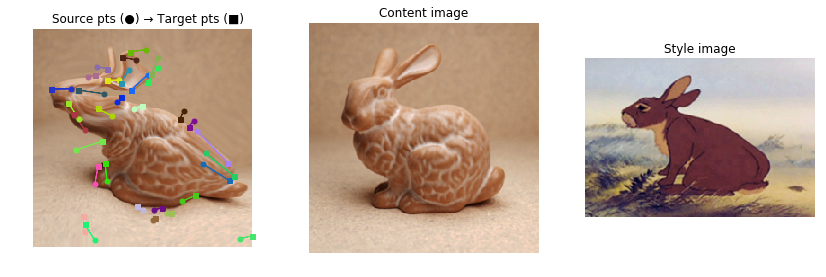

In [21]:
fig = plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.imshow(content_im_warped);
for j in range(target_pts.shape[0]):
    plt.plot(source_pts[j][1], source_pts[j][0], marker='o', color=colors[j], markersize=5)
    plt.plot(target_pts[j][1], target_pts[j][0], marker='s', color=colors[j], markersize=5)
    plt.arrow(source_pts[j][1], source_pts[j][0], target_pts[j][1]-source_pts[j][1], 
              target_pts[j][0]-source_pts[j][0], color=colors[j], width=0.05)
plt.axis('off')
plt.title('Source pts (●) → Target pts (■)');

plt.subplot(1, 3, 2)
plt.imshow(content_resized);
plt.axis('off')
plt.title('Content image');

plt.subplot(1, 3, 3)
plt.imshow(style_resized);
plt.axis('off')
plt.title('Style image');